In [39]:
import pandas as pd
import numpy as np
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Dropout, Activation, Input

# Verificar que la GPU está disponible
physical_devices = tf.config.list_physical_devices('GPU')
if len(physical_devices) > 0:
    print("GPU disponible.")
else:
    print("GPU no disponible.")

GPU no disponible.


In [40]:
# Crear la carpeta 'resultados' si no existe
if not os.path.exists('resultados'):
    os.makedirs('resultados')

In [41]:
# Cargar los datos
cleaned_data_path = '../datasets/cleaned_data.csv'
data_all = pd.read_csv(cleaned_data_path)

C:\Users\Ketbome\AppData\Local\Temp\ipykernel_3652\909222528.py:3: DtypeWarning: Columns (25) have mixed types. Specify dtype option on import or set low_memory=False.
  data_all = pd.read_csv(cleaned_data_path)


In [42]:
data_all.head()

ï»¿AGNO  RBD  DGV_RBD                  NOM_RBD  COD_REG_RBD NOM_REG_RBD_A  \
0     2022    1        9  LICEO POLITECNICO ARICA           15           AYP   
1     2022    1        9  LICEO POLITECNICO ARICA           15           AYP   
2     2022    1        9  LICEO POLITECNICO ARICA           15           AYP   
3     2022    1        9  LICEO POLITECNICO ARICA           15           AYP   
4     2022    1        9  LICEO POLITECNICO ARICA           15           AYP   

   COD_PRO_RBD  COD_COM_RBD NOM_COM_RBD  COD_DEPROV_RBD  ... COD_COM_ALU  \
0          151        15101       ARICA             151  ...       15101   
1          151        15101       ARICA             151  ...       15101   
2          151        15101       ARICA             151  ...       15101   
3          151        15101       ARICA             151  ...       15101   
4          151        15101       ARICA             151  ...       15101   

   NOM_COM_ALU  COD_RAMA  COD_SEC  COD_ESPE  PROM_GRAL  ASISTENCIA  SIT_FIN  \
0        ARICA       400      410     41001        6.6          98        P   
1        ARICA       400      410     41001        6.2          85        P   
2        ARICA       400      410     41001        6.3          86        P   
3        ARICA       400      410     41001        6.3         100        P   
4        ARICA       400      410     41001        6.7         100        P   

  SIT_FIN_R  COD_MEN  
0         P        0  
1         P        0  
2         P        0  
3         P        0  
4         P        0  

[5 rows x 37 columns]

In [43]:
# Convertir la columna a números, los valores inválidos se convierten en NaN
data_all['EDAD_ALU'] = pd.to_numeric(data_all['EDAD_ALU'], errors='coerce')

# Eliminar las filas con NaN en la columna 'EDAD_ALU'
data_all = data_all.dropna(subset=['EDAD_ALU'])

# Borrar las filas donde la columna 'COD_SEC' sea distinto de 0
data_all = data_all[data_all['COD_SEC'] == 0] # Solo alumnos de basica y media

# Eliminar la columna 'COD_ENSE'
data_all = data_all.drop(columns=['COD_ENSE'])

In [44]:
data_all.isna().sum()

ï»¿AGNO           0
RBD               0
DGV_RBD           0
NOM_RBD           0
COD_REG_RBD       0
NOM_REG_RBD_A     0
COD_PRO_RBD       0
COD_COM_RBD       0
NOM_COM_RBD       0
COD_DEPROV_RBD    0
NOM_DEPROV_RBD    0
COD_DEPE          0
COD_DEPE2         0
RURAL_RBD         0
ESTADO_ESTAB      0
COD_ENSE2         0
COD_GRADO         0
LET_CUR           0
COD_JOR           0
COD_TIP_CUR       0
COD_DES_CUR       0
MRUN              0
GEN_ALU           0
FEC_NAC_ALU       0
EDAD_ALU          0
COD_REG_ALU       0
COD_COM_ALU       0
NOM_COM_ALU       0
COD_RAMA          0
COD_SEC           0
COD_ESPE          0
PROM_GRAL         0
ASISTENCIA        0
SIT_FIN           0
SIT_FIN_R         0
COD_MEN           0
dtype: int64

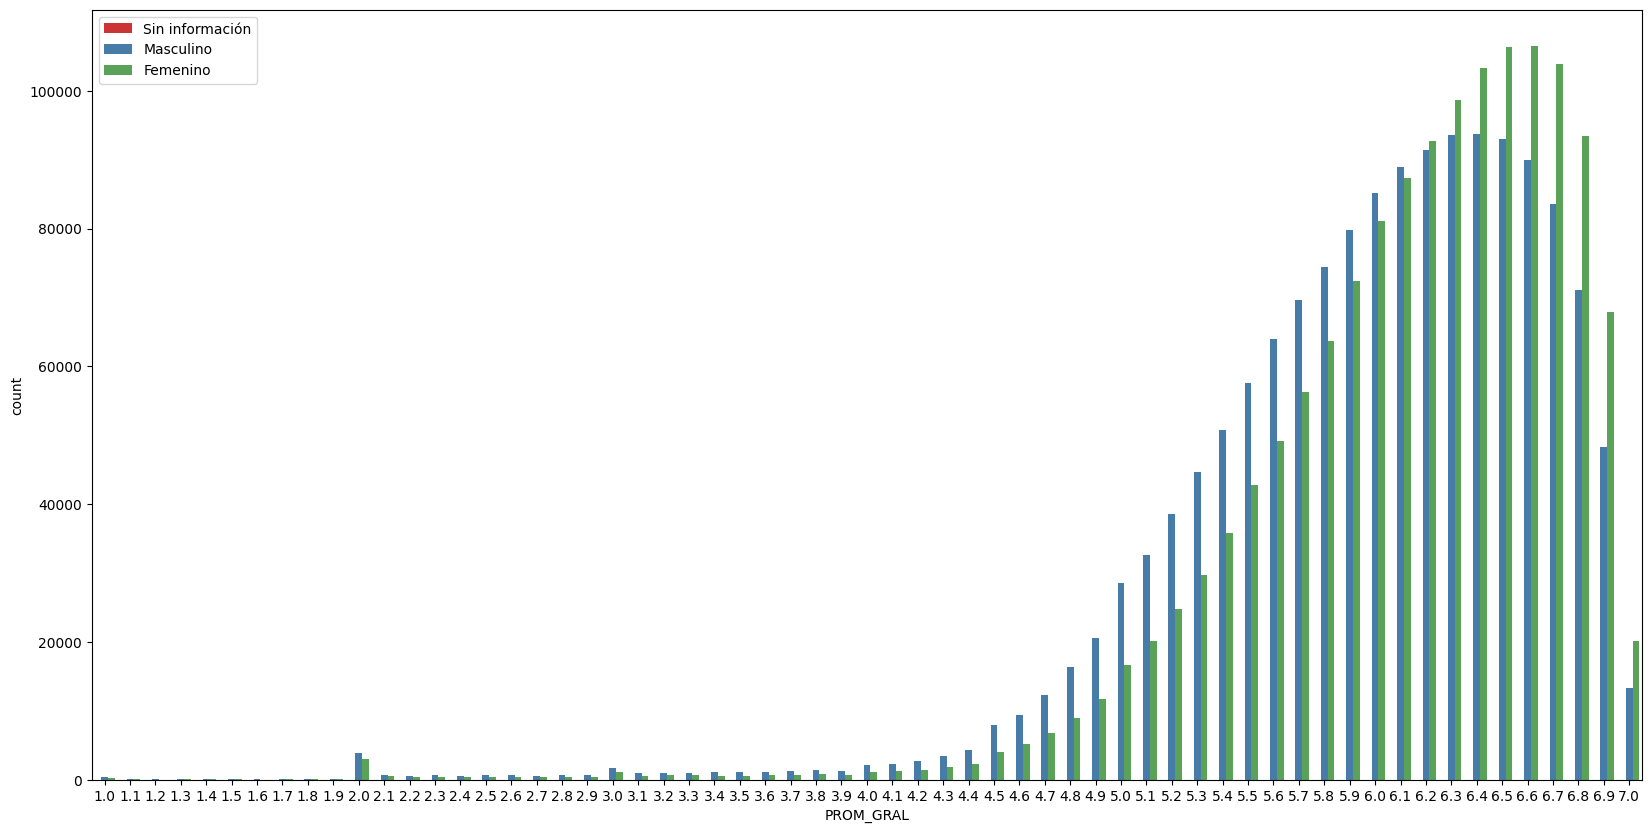

In [45]:
import seaborn as sb
import matplotlib.pyplot as plt


plt.figure(figsize=(20,10))
sb.countplot(x='PROM_GRAL', data=data_all, hue='GEN_ALU', palette='Set1')
plt.legend(["Sin información", "Masculino", "Femenino"])


In [46]:
# Observar correlacion para hacer mas limpieza
numeric_columns = data_all.select_dtypes(include=np.number).columns
correlacion_all = data_all[numeric_columns].corr()

# Ver correlacion en base a valor a evaluar
correlacion_prom_gral = correlacion_all["PROM_GRAL"].sort_values(ascending=False)
correlacion_prom_gral

PROM_GRAL         1.000000
ASISTENCIA        0.353526
FEC_NAC_ALU       0.346272
GEN_ALU           0.113676
COD_DEPE          0.057404
MRUN              0.054466
COD_DEPE2         0.049517
RURAL_RBD         0.027529
COD_TIP_CUR       0.021308
DGV_RBD          -0.003853
COD_REG_ALU      -0.009950
COD_COM_ALU      -0.010334
COD_REG_RBD      -0.015331
COD_COM_RBD      -0.015470
COD_PRO_RBD      -0.015492
COD_DEPROV_RBD   -0.022988
RBD              -0.036958
COD_GRADO        -0.052895
COD_JOR          -0.084066
COD_ENSE2        -0.257659
EDAD_ALU         -0.348045
ï»¿AGNO                NaN
ESTADO_ESTAB           NaN
COD_DES_CUR            NaN
COD_RAMA               NaN
COD_SEC                NaN
COD_ESPE               NaN
COD_MEN                NaN
Name: PROM_GRAL, dtype: float64

In [74]:
# Obtener nombres de las columnas de correlacion distintas que no sean Nan
columnas_seleccionadas = correlacion_prom_gral[correlacion_prom_gral.notna()].index

In [92]:
# Obtén los nombres de las columnas con correlación mayor a 0.1
columnas_mayor_0_1 = correlacion_prom_gral[correlacion_prom_gral > 0.057].index

# Obtén los nombres de las columnas con correlación menor a -0.1
columnas_menor_neg_0_1 = correlacion_prom_gral[correlacion_prom_gral < -0.05].index

columnas_seleccionadas = columnas_mayor_0_1.tolist() + columnas_menor_neg_0_1.tolist()

# Agregar comuna del colegio
columnas_seleccionadas.append('COD_COM_RBD')
#columnas_seleccionadas.append('DGV_RBD')

columnas_seleccionadas

['PROM_GRAL',
 'ASISTENCIA',
 'FEC_NAC_ALU',
 'GEN_ALU',
 'COD_DEPE',
 'COD_GRADO',
 'COD_JOR',
 'COD_ENSE2',
 'EDAD_ALU',
 'COD_COM_RBD']

In [105]:
# Columnas
#['ï»¿AGNO', 'RBD', 'DGV_RBD', 'NOM_RBD', 'COD_REG_RBD', 'NOM_REG_RBD_A', 'COD_PRO_RBD', 'COD_COM_RBD', 
#'NOM_COM_RBD', 'COD_DEPROV_RBD', 'NOM_DEPROV_RBD', 'COD_DEPE', 'COD_DEPE2', 'RURAL_RBD', 'ESTADO_ESTAB',
#'COD_ENSE', 'COD_ENSE2', 'COD_GRADO', 'LET_CUR', 'COD_JOR',
#'COD_TIP_CUR', 'COD_DES_CUR', 'MRUN', 'GEN_ALU', 'FEC_NAC_ALU',
#'EDAD_ALU', 'COD_REG_ALU', 'COD_COM_ALU', 'NOM_COM_ALU', 'COD_RAMA',
#'COD_SEC', 'COD_ESPE', 'PROM_GRAL', 'ASISTENCIA', 'SIT_FIN',
#'SIT_FIN_R', 'COD_MEN']

# Hacer data = data_all con las columnas a usar EDAD_ALU, GEN_ALU, PROM_GRAL
#data = data_all[['COD_COM_RBD', 'COD_DEPE2', 'RURAL_RBD', 'COD_ENSE2', 'COD_GRADO', 'COD_JOR', 'GEN_ALU', 'EDAD_ALU', 'PROM_GRAL', 'ASISTENCIA']]
data_clear = data_all[columnas_seleccionadas]
data = data_clear.drop('FEC_NAC_ALU', axis=1)
data.head()

PROM_GRAL  ASISTENCIA  GEN_ALU  COD_DEPE  COD_GRADO  COD_JOR  COD_ENSE2  \
7         4.5          85        1         6          1        1          7   
8         5.1          89        1         6          1        1          7   
9         5.3          89        1         6          1        1          7   
10        5.9          90        2         6          1        1          7   
11        5.7          90        1         6          1        1          7   

    EDAD_ALU  COD_COM_RBD  
7       14.0        15101  
8       15.0        15101  
9       16.0        15101  
10      16.0        15101  
11      14.0        15101

<Axes: >

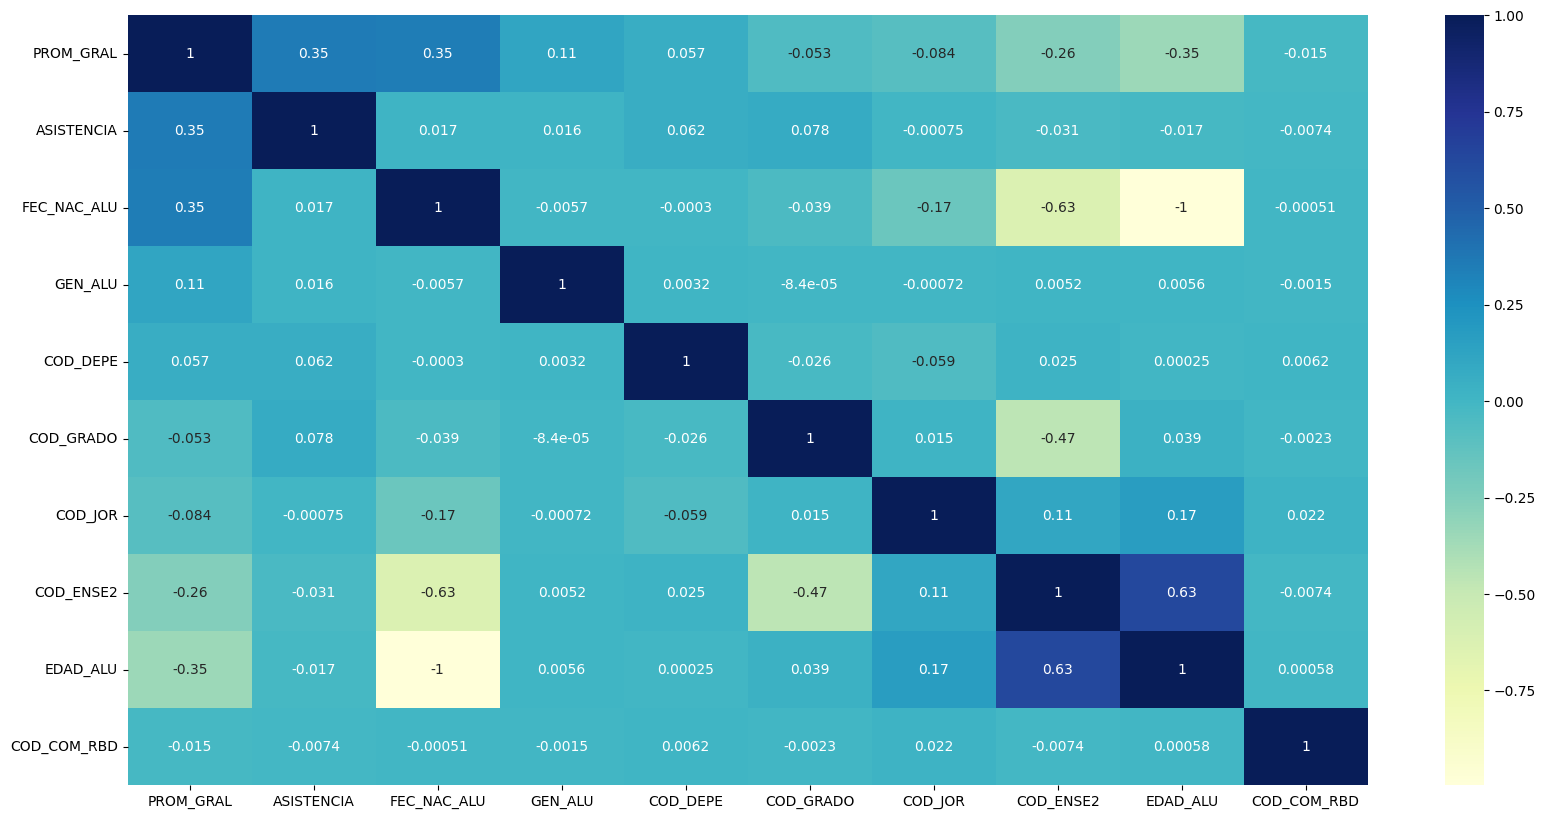

In [50]:
#Observar correlacion para hacer mas limpieza
plt.figure(figsize=(20,10))
sb.heatmap(data.corr(), annot=True, cmap='YlGnBu')


In [77]:
# Ver correlacion en base a valor a evaluar
data.corr()["PROM_GRAL"].sort_values(ascending=False)

PROM_GRAL         1.000000
ASISTENCIA        0.353526
FEC_NAC_ALU       0.346272
GEN_ALU           0.113676
COD_DEPE          0.057404
MRUN              0.054466
COD_DEPE2         0.049517
RURAL_RBD         0.027529
COD_TIP_CUR       0.021308
DGV_RBD          -0.003853
COD_REG_ALU      -0.009950
COD_COM_ALU      -0.010334
COD_REG_RBD      -0.015331
COD_COM_RBD      -0.015470
COD_PRO_RBD      -0.015492
COD_DEPROV_RBD   -0.022988
RBD              -0.036958
COD_GRADO        -0.052895
COD_JOR          -0.084066
COD_ENSE2        -0.257659
EDAD_ALU         -0.348045
Name: PROM_GRAL, dtype: float64

In [52]:
# Saber cuantas filas hay y columnas
pd.DataFrame([data.shape], columns=['Filas', 'Columnas'])

Filas  Columnas
0  2929038        10

In [107]:
# División de datos
X = data.drop(columns=['PROM_GRAL'])
y = data['PROM_GRAL']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

In [106]:
from sklearn.preprocessing import StandardScaler
from tensorflow.keras import layers

# Escalado de características
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train) # Ajustar y transformar
X_test_scaled = scaler.transform(X_test) # Solo transformar

In [96]:
model = keras.Sequential([
    layers.Dense(X_train_scaled.shape[1], activation='relu', input_shape=[X_train_scaled.shape[1]]),
    layers.Dense(288, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(144, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(1)
])

In [97]:
learning_rate = 0.001

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
    loss='mae', # todos los tipos de pérdida: https://keras.io/api/losses/
    metrics=['mse'] # todas las métricas: https://keras.io/api/metrics/],
)

In [98]:
# Entrenamiento
model.fit(
    X_train_scaled, y_train,
    validation_split=0.2,
    epochs=20,
    batch_size=1024,
    verbose=1
)

Epoch 1/20
1831/1831 [==============================] - 17s 8ms/step - loss: 0.6220 - mse: 0.8584 - val_loss: 0.4222 - val_mse: 0.3252
Epoch 2/20
1831/1831 [==============================] - 15s 8ms/step - loss: 0.5053 - mse: 0.4329 - val_loss: 0.4180 - val_mse: 0.3115
Epoch 3/20
1831/1831 [==============================] - 15s 8ms/step - loss: 0.4782 - mse: 0.3916 - val_loss: 0.4141 - val_mse: 0.3106
Epoch 4/20
1831/1831 [==============================] - 15s 8ms/step - loss: 0.4599 - mse: 0.3664 - val_loss: 0.4143 - val_mse: 0.3030
Epoch 5/20
1831/1831 [==============================] - 15s 8ms/step - loss: 0.4456 - mse: 0.3470 - val_loss: 0.4135 - val_mse: 0.3044
Epoch 6/20
1831/1831 [==============================] - 15s 8ms/step - loss: 0.4345 - mse: 0.3327 - val_loss: 0.4100 - val_mse: 0.3050
Epoch 7/20
1831/1831 [==============================] - 15s 8ms/step - loss: 0.4268 - mse: 0.3233 - val_loss: 0.4088 - val_mse: 0.3053
Epoch 8/20
1831/1831 [==============================] -

In [99]:
# Hacer una predicción
predicciones = model.predict(X_test_scaled)

18307/18307 [==============================] - 24s 1ms/step


In [100]:
# aproximar a 1 decimal
predicciones = np.round(predicciones, 1)

In [101]:
print(f"Prediccion: {predicciones[6]}, Real: {y_test.iloc[6]}")

Prediccion: [6.2], Real: 6.3


In [104]:
# Calcular el error absoluto medio
mae = mean_absolute_error(y_test, predicciones)
print('MAE: %.3f' % mae)

# Calcular el error cuadrático medio
mse = mean_squared_error(y_test, predicciones)
print('MSE: %.3f' % mse)

# Calcular el coeficiente de determinación
r2 = r2_score(y_test, predicciones)
print('R2: %.3f' % r2)

MAE: 0.406
MSE: 0.303
R2: 0.359


In [85]:
# Guardar el modelo
model.save("./models/RedNeuronal4.h5")
# Guardar el modelo
model.save("./models/nn_model4")

c:\Python311\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: ./models/nn_model3\assets


INFO:tensorflow:Assets written to: ./models/nn_model3\assets


In [90]:
# Guardar los resultados
results = pd.DataFrame({'Modelo': ['Neural Network'],
                        'MSE': [mse],
                        'MAE': [mae],
                        'R2': [r2]})
results.to_csv('resultados/RedNeuronal3.csv', index=False)
